# Template for ML evaluation

There are a few features of the evaluation module, which are explained below. 

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import sys
sys.path.append('../modules/')

%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-04-04 22:42:49.044624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-04 22:42:49.063417: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-04 22:42:49.069006: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# We need one place to save all the experiment relevant info.  
common_config= {'simulation_names':['DG','P2L'],  # What data sets to train on
                    'filter_scales':['50','100','200','400'], # What filter scales to train on
                    'window_size':1,  # What stencil we want to train on 
                    'all_ml_variables' : ['dudx_widened_rotated_nondim',  # must include all variables, inputs, outputs, 
                                          'dvdx_widened_rotated_nondim',  # including those used as coefficients (if you want to train y = coeff_var * ANN (x)
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim',
                                          'uphp_rotated_nondim',  # Note these non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated_nondim'], # And will require user to change SimulationData class if normalization needs changing
                    
                    'input_channels' :   ['dudx_widened_rotated_nondim',  # Inputs to ANN
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim'],
                    
                    'output_channels' :  ['uphp_rotated_nondim', # Outputs from ANN
                                          'vphp_rotated_nondim'],

                    'use_coeff_channels': False,
                    'coeff_channels'  : [],  # If any coefficients are used

                    'extra_channels'   : [  'uphp_rotated', # These are used during evaluation to go back to dimensional units. 
                                            'vphp_rotated', 
                                            'mag_nabla_h_widened',
                                            'mag_nabla_u_widened',
                                            'filter_scale'],

                    
                    'single_layer_mask': True, # A mask that says whether regions where only one dynamic layer is present should be masked out during training.

                    # The parameters below set how large the datasets need to be etc
                    'all_time_range': slice(0, 768),
                    'train_time_range': slice(0, 128*3),
                    'test_time_range' : slice(128*3, 128*4),
                    'eval_time_range' : slice(128*4, 128*5),
                    'num_train_batches': 3*8, # Each batch will have 16 snapshots
                    'num_test_batches' : 8, # Each batch will have 16 snapshots

                    #'num_inputs': 9*6, # Based on number of inputs and the stencil sizes
                    'num_inputs': 1*6, # Based on number of inputs and the stencil sizes
                    'network_shape': [48, 48, 2], #Shape of network

                    # Set location where the ckpt will be saved
                    'ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/template_trained/shape_48_48_2/'
                    
            }

In [3]:
DT = datasets.SimulationData(simulation_names=common_config['simulation_names'], 
                             filter_scales=common_config['filter_scales'], 
                             window_size = common_config['window_size'], 
                             time_sel = common_config['all_time_range'],
                             single_layer_mask_flag=common_config['single_layer_mask']
                             )

In [4]:
DT.simulation_data

DataTree('None', parent=None)
├── DataTree('DG')
│   ├── DataTree('50')
│   │       Dimensions:                      (Time: 768, xh: 200, yh: 218, zl: 2, Xn: 1,
│   │                                         Yn: 1, zi: 3)
│   │       Coordinates:
│   │         * Time                         (Time) object 6kB 0001-01-11 00:00:00 ... 00...
│   │         * xh                           (xh) float64 2kB 0.055 0.165 ... 21.84 21.95
│   │         * yh                           (yh) float64 2kB 30.14 30.23 ... 49.77 49.86
│   │         * zl                           (zl) float64 16B 1.035e+03 1.036e+03
│   │         * zi                           (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
│   │       Dimensions without coordinates: Xn, Yn
│   │       Data variables: (12/67)
│   │           dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 536MB dask.array<chunksize=(36, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 536MB dask.array<chunksize=(36, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 536MB dask.array<chunksize=(36, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dvdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 536MB dask.array<chunksize=(36, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dhdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 536MB dask.array<chunksize=(36, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dhdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 536MB dask.array<chunksize=(36, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           ...                           ...
│   │           uphp_rotated_nondim          (Time, zl, yh, xh) float64 536MB dask.array<chunksize=(36, 2, 218, 200), meta=np.ndarray>
│   │           vphp_rotated_nondim          (Time, zl, yh, xh) float64 536MB dask.array<chunksize=(36, 2, 218, 200), meta=np.ndarray>
│   │           uphp_nondim                  (Time, zl, yh, xh) float64 536MB dask.array<chunksize=(36, 2, 218, 200), meta=np.ndarray>
│   │           vphp_nondim                  (Time, zl, yh, xh) float64 536MB dask.array<chunksize=(36, 2, 218, 200), meta=np.ndarray>
│   │           Rd_nondim                    (Time, yh, xh) float64 268MB dask.array<chunksize=(36, 218, 200), meta=np.ndarray>
│   │           single_layer_mask            (Time, yh, xh) float64 268MB dask.array<chunksize=(36, 218, 200), meta=np.ndarray>
│   │       Attributes:
│   │           simulation_name:  DG
│   │           filter_scale:     50
│   │           source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
│   │           description:      Dataset for DG experiment at 50 km resolution
│   ├── DataTree('100')
│   │       Dimensions:                      (Time: 768, xh: 100, yh: 108, zl: 2, Xn: 1,
│   │                                         Yn: 1, zi: 3)
│   │       Coordinates:
│   │         * Time                         (Time) object 6kB 0001-01-11 00:00:00 ... 00...
│   │         * xh                           (xh) float64 800B 0.11 0.33 ... 21.67 21.89
│   │         * yh                           (yh) float64 864B 30.27 30.45 ... 49.55 49.73
│   │         * zl                           (zl) float64 16B 1.035e+03 1.036e+03
│   │         * zi                           (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
│   │       Dimensions without coordinates: Xn, Yn
│   │       Data variables: (12/67)
│   │           dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 133MB dask.array<chunksize=(36, 2, 108, 100, 1, 1), meta=np.ndarray>
│   │           dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 133MB dask.array<chunksize=(36, 2, 108, 100, 1, 1), meta=np.ndarray>
│   │           dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 133MB dask.array<chunksize=(36, 2, 108, 100, 1, 1), meta=np.ndarray>
│   │           dvdy_widened  

### Setting up the evaluation module and the basics

In [ ]:
eval_sys = evaluation.EvalSystem(simulation_data=DT,
                                             input_channels=common_config['input_channels'],
                                             output_channels=common_config['output_channels'], 
                                             coeff_channels=common_config['coeff_channels'], 
                                             extra_channels=common_config['extra_channels'],
                                             use_norm_factors=True,
                                             eval_time_slice= common_config['eval_time_range'], 
                                             num_inputs= common_config['num_inputs'], 
                                             shape=common_config['network_shape'], 
                                             ckpt_dir=common_config['ckpt_save_dir'],
                                             use_coeff_channels=common_config['use_coeff_channels'])

In [7]:
eval_sys.read_ann_regression_model()
eval_sys.read_eval_data()

In [13]:
eval_sys.predict()

In [14]:
eval_sys.dimensionalize()

In [15]:
eval_sys.eval_datatree.ml_dataset

DataTree('None', parent=None)
├── DataTree('DG')
│   ├── DataTree('50')
│   │       Dimensions:                      (Time: 128, zl: 2, yh: 218, xh: 200, Xn: 1,
│   │                                         Yn: 1)
│   │       Coordinates:
│   │         * Time                         (Time) object 1kB 0015-01-18 00:00:00 ... 00...
│   │         * xh                           (xh) float64 2kB 0.055 0.165 ... 21.84 21.95
│   │         * yh                           (yh) float64 2kB 30.14 30.23 ... 49.77 49.86
│   │         * zl                           (zl) float64 16B 1.035e+03 1.036e+03
│   │       Dimensions without coordinates: Xn, Yn
│   │       Data variables: (12/18)
│   │           dudx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 89MB dask.array<chunksize=(28, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dvdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 89MB dask.array<chunksize=(28, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dudy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 89MB dask.array<chunksize=(28, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dvdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 89MB dask.array<chunksize=(28, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dhdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 89MB dask.array<chunksize=(28, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dhdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 89MB dask.array<chunksize=(28, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           ...                           ...
│   │           filter_scale                 (yh, xh, Time) float64 45MB dask.array<chunksize=(218, 200, 28), meta=np.ndarray>
│   │           h_mask                       (Time, zl, yh, xh) float64 89MB dask.array<chunksize=(28, 2, 218, 200), meta=np.ndarray>
│   │           uphp_rotated_nondim_pred     (Time, zl, yh, xh) float64 89MB dask.array<chunksize=(28, 2, 218, 200), meta=np.ndarray>
│   │           vphp_rotated_nondim_pred     (Time, zl, yh, xh) float64 89MB dask.array<chunksize=(28, 2, 218, 200), meta=np.ndarray>
│   │           uphp_rotated_pred            (Time, zl, yh, xh) float64 89MB dask.array<chunksize=(28, 2, 218, 200), meta=np.ndarray>
│   │           vphp_rotated_pred            (Time, zl, yh, xh) float64 89MB dask.array<chunksize=(28, 2, 218, 200), meta=np.ndarray>
│   │       Attributes:
│   │           simulation_name:  DG
│   │           filter_scale:     50
│   │           source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
│   │           description:      Dataset for DG experiment at 50 km resolution
│   ├── DataTree('100')
│   │       Dimensions:                      (Time: 128, zl: 2, yh: 108, xh: 100, Xn: 1,
│   │                                         Yn: 1)
│   │       Coordinates:
│   │         * Time                         (Time) object 1kB 0015-01-18 00:00:00 ... 00...
│   │         * xh                           (xh) float64 800B 0.11 0.33 ... 21.67 21.89
│   │         * yh                           (yh) float64 864B 30.27 30.45 ... 49.55 49.73
│   │         * zl                           (zl) float64 16B 1.035e+03 1.036e+03
│   │       Dimensions without coordinates: Xn, Yn
│   │       Data variables: (12/18)
│   │           dudx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 22MB dask.array<chunksize=(28, 2, 108, 100, 1, 1), meta=np.ndarray>
│   │           dvdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 22MB dask.array<chunksize=(28, 2, 108, 100, 1, 1), meta=np.ndarray>
│   │           dudy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 22MB dask.array<chunksize=(28, 2, 108, 100, 1, 1), meta=np.ndarray>
│   │           dvdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 22MB dask.array<chunksize=(28, 2, 108, 100, 1, 1), meta=np.ndarray>
│   │           dhdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 22MB das

In [16]:
plt.figure(figsize=(8,3))

plt.subplot(121)
eval_sys.eval_datatree.ml_dataset['P2L']['50'].vphp_rotated.isel(Time=0, zl=0).plot()

plt.subplot(122)
eval_sys.eval_datatree.ml_dataset['P2L']['50'].vphp_rotated_pred.isel(Time=0, zl=0).plot()

plt.tight_layout()

### Calculating metrics

### Working with online data
This is unfiltered data, which just directly comes from a lower resolution simulation. 

In [9]:
DT_online = datasets.SimulationData(simulation_names=['P2L'], 
                             filter_scales=['100'], 
                             window_size = 3, 
                             single_layer_mask_flag=common_config['single_layer_mask'],
                             data_form = 'regular' ,
                             online_window_value = 3,
                             add_middle_interface = False,
                             add_layer_decomposition = False,
                             variables_to_widen = ['dudx','dvdx','dudy','dvdy','dhdx','dhdy']      
                             )

eval_sys_online_3 = evaluation.EvalSystem(simulation_data=DT_online,
                                             input_channels=common_config['input_channels'],
                                             output_channels=common_config['output_channels'], 
                                             coeff_channels=common_config['coeff_channels'], 
                                             extra_channels=common_config['extra_channels'],
                                             use_norm_factors=True,
                                             eval_time_slice= slice(0, -1), 
                                             num_inputs= common_config['num_inputs'], 
                                             shape=common_config['network_shape'], 
                                             ckpt_dir='/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/template_trained/shape_48_48_2_window3/',
                                             use_coeff_channels=common_config['use_coeff_channels'])

eval_sys_online_3.read_ann_regression_model()
eval_sys_online_3.read_eval_data()
eval_sys_online_3.predict()
eval_sys_online_3.dimensionalize()

~/mesoscale_buoyancy_param_ML/online_analysis_Greene/Phillips2Layer/example_data_window3.netcdf


In [10]:
DT_online = datasets.SimulationData(simulation_names=['P2L'], 
                             filter_scales=['100'], 
                             window_size = 1, 
                             single_layer_mask_flag=common_config['single_layer_mask'],
                             data_form = 'regular' ,
                             online_window_value= 1, 
                             add_middle_interface = False,
                             add_layer_decomposition = False,
                             variables_to_widen = ['dudx','dvdx','dudy','dvdy','dhdx','dhdy']      
                             )

eval_sys_online_1 = evaluation.EvalSystem(simulation_data=DT_online,
                                             input_channels=common_config['input_channels'],
                                             output_channels=common_config['output_channels'], 
                                             coeff_channels=common_config['coeff_channels'], 
                                             extra_channels=common_config['extra_channels'],
                                             use_norm_factors=True,
                                             eval_time_slice= slice(0, -1), 
                                             num_inputs= common_config['num_inputs'], 
                                             shape=common_config['network_shape'], 
                                             ckpt_dir='/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/template_trained/shape_48_48_2/',
                                             use_coeff_channels=common_config['use_coeff_channels'])

eval_sys_online_1.read_ann_regression_model()
eval_sys_online_1.read_eval_data()
eval_sys_online_1.predict()
eval_sys_online_1.dimensionalize()

~/mesoscale_buoyancy_param_ML/online_analysis_Greene/Phillips2Layer/example_data.netcdf


In [11]:
eval_sys_online_3.eval_datatree.ml_dataset['P2L']['100'].dudx_widened_rotated_nondim

<xarray.DataArray 'dudx_widened_rotated_nondim' (Time: 14, zl: 2, yh: 80,
                                                 xh: 60, Xn: 3, Yn: 3)> Size: 10MB
array([[[[[[            nan,             nan,             nan],
           [            nan, -4.67260278e-01, -4.86206542e-01],
           [            nan, -4.58863383e-01, -4.77643302e-01]],

          [[            nan, -4.00300150e-01, -3.99699422e-01],
           [            nan, -3.97366806e-01, -3.96378146e-01],
           [            nan, -3.96035491e-01, -3.95256866e-01]],

          [[            nan, -3.20931276e-01, -2.92623663e-01],
           [            nan, -3.12259937e-01, -2.85317508e-01],
           [            nan, -3.07412354e-01, -2.80036823e-01]],

          ...,

          [[            nan, -3.08208144e-01, -2.79188406e-01],
           [            nan, -3.04034450e-01, -2.76090225e-01],
           [            nan, -3.06565762e-01, -2.76953897e-01]],

          [[            nan, -3.63834345e-01, -3.44733889e-01],
           [            nan, -3.63025438e-01, -3.43575295e-01],
...
           [ 2.74662252e-01,  2.75557490e-01,             nan],
           [ 2.83738021e-01,  2.83283523e-01,             nan]],

          [[ 2.69211051e-01,  2.69409823e-01,             nan],
           [ 2.78019858e-01,  2.76955319e-01,             nan],
           [ 2.81884206e-01,  2.81785955e-01,             nan]],

          ...,

          [[ 2.55569273e-01,  2.56412709e-01,             nan],
           [ 2.91181091e-01,  2.87322693e-01,             nan],
           [ 3.21003481e-01,  3.15338456e-01,             nan]],

          [[ 2.61777301e-01,  2.62019942e-01,             nan],
           [ 2.89557094e-01,  2.87948678e-01,             nan],
           [ 3.14287321e-01,  3.09028719e-01,             nan]],

          [[ 3.34990350e-01,  3.36724067e-01,             nan],
           [ 3.64438108e-01,  3.61656558e-01,             nan],
           [            nan,             nan,             nan]]]]]])
Coordinates:
  * yh       (yh) float64 640B 10.0 30.0 50.0 ... 1.55e+03 1.57e+03 1.59e+03
  * zl       (zl) float64 16B 1.031e+03 1.033e+03
  * Time     (Time) object 112B 0001-01-11 00:00:00 ... 0001-05-21 00:00:00
  * xh       (xh) float64 480B 10.0 30.0 50.0 ... 1.15e+03 1.17e+03 1.19e+03
Dimensions without coordinates: Xn, Yn

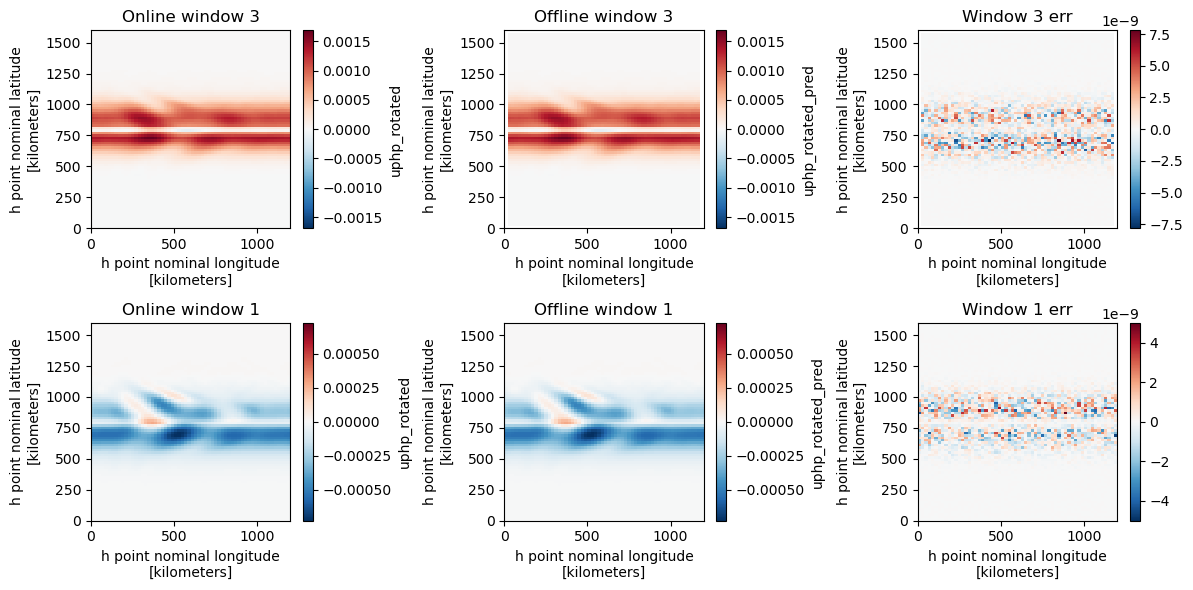

In [12]:
plt.figure(figsize=(12, 6))
idT = 2

var = 'uphp'

plt.subplot(231)
eval_sys_online_3.eval_datatree.ml_dataset['P2L']['100'][var+'_rotated'].isel(Time=idT, zl=0).plot()
plt.title('Online window 3')

plt.subplot(232)
(eval_sys_online_3.eval_datatree.ml_dataset['P2L']['100'][var+'_rotated_pred']/25. ).isel(Time=idT, zl=0).plot() # This factor of 
plt.title('Offline window 3')


plt.subplot(233)
(eval_sys_online_3.eval_datatree.ml_dataset['P2L']['100'][var+'_rotated_pred']/25. - eval_sys_online_3.eval_datatree.ml_dataset['P2L']['100'][var+'_rotated']).isel(Time=idT, zl=0).plot() # This factor of 
plt.title('Window 3 err')


plt.subplot(234)
eval_sys_online_1.eval_datatree.ml_dataset['P2L']['100'][var+'_rotated'].isel(Time=idT, zl=0).plot()
plt.title('Online window 1')

plt.subplot(235)
(eval_sys_online_1.eval_datatree.ml_dataset['P2L']['100'][var+'_rotated_pred']/25.).isel(Time=idT, zl=0).plot() # This factor of 
plt.title('Offline window 1')

plt.subplot(236)
(eval_sys_online_1.eval_datatree.ml_dataset['P2L']['100'][var+'_rotated_pred']/25. - eval_sys_online_1.eval_datatree.ml_dataset['P2L']['100'][var+'_rotated']).isel(Time=idT, zl=0).plot() # This factor of 
plt.title('Window 1 err')

plt.tight_layout()

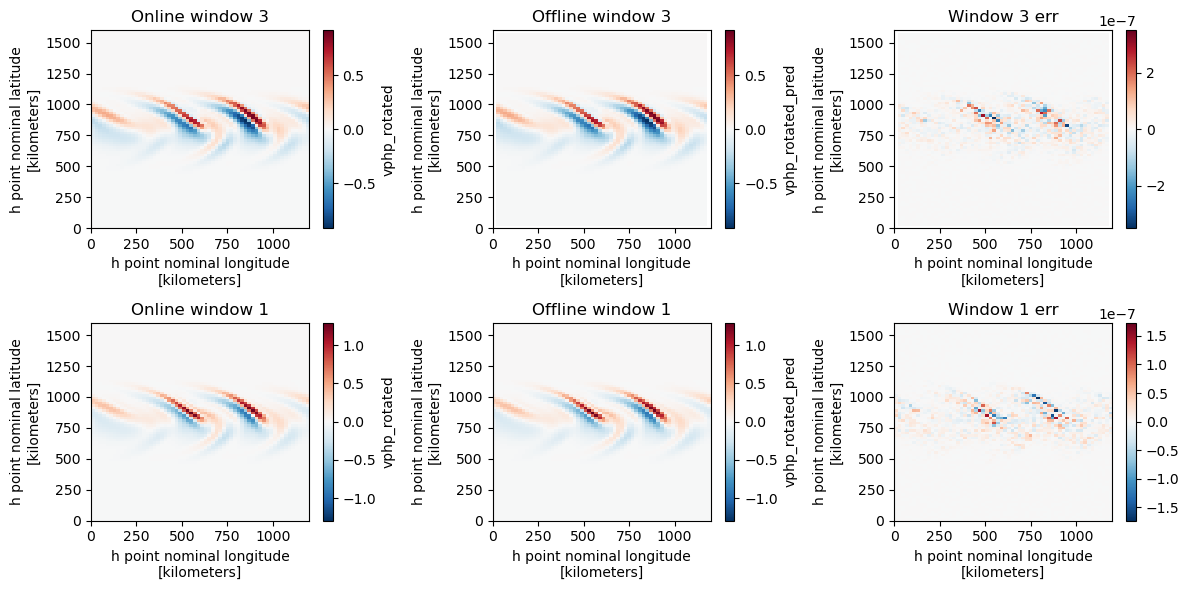

In [13]:
plt.figure(figsize=(12, 6))
idT = 12

var = 'vphp'

plt.subplot(231)
eval_sys_online_3.eval_datatree.ml_dataset['P2L']['100'][var+'_rotated'].isel(Time=idT, zl=0).plot()
plt.title('Online window 3')

plt.subplot(232)
(eval_sys_online_3.eval_datatree.ml_dataset['P2L']['100'][var+'_rotated_pred']/25. ).isel(Time=idT, zl=0).plot() # This factor of 
plt.title('Offline window 3')


plt.subplot(233)
(eval_sys_online_3.eval_datatree.ml_dataset['P2L']['100'][var+'_rotated_pred']/25. - eval_sys_online_3.eval_datatree.ml_dataset['P2L']['100'][var+'_rotated']).isel(Time=idT, zl=0).plot() # This factor of 
plt.title('Window 3 err')


plt.subplot(234)
eval_sys_online_1.eval_datatree.ml_dataset['P2L']['100'][var+'_rotated'].isel(Time=idT, zl=0).plot()
plt.title('Online window 1')

plt.subplot(235)
(eval_sys_online_1.eval_datatree.ml_dataset['P2L']['100'][var+'_rotated_pred']/25.).isel(Time=idT, zl=0).plot() # This factor of 
plt.title('Offline window 1')

plt.subplot(236)
(eval_sys_online_1.eval_datatree.ml_dataset['P2L']['100'][var+'_rotated_pred']/25. - eval_sys_online_1.eval_datatree.ml_dataset['P2L']['100'][var+'_rotated']).isel(Time=idT, zl=0).plot() # This factor of 
plt.title('Window 1 err')

plt.tight_layout()

In [20]:
DT = datasets.SimulationData(simulation_names=common_config['simulation_names'], 
                             filter_scales=common_config['filter_scales'], 
                             window_size = common_config['window_size'], 
                             time_sel = common_config['all_time_range'],
                             single_layer_mask_flag=False
                             )

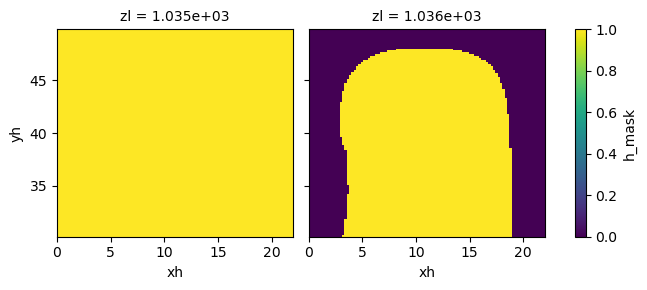

In [21]:
DT.simulation_data['DG']['100'].h_mask.isel(Time=-1).plot(col='zl')